# Домашнее задание 5

__Дедлайн: 18.12.2022, 23:59__

Дедлайн является более жёстким, чем обычно. Ваши баллы будут убывать за опоздание на каждые полчаса до нуля в течение 10 часов . Т.е. человек приславший 19.12.2022 в 00:01 получит 19/20 баллов, а приславший в 09:30 - 1/20. 

Файлы должны иметь имя HW4_ФАМИЛИЯ.ipynb, где ФАМИЛИЯ - Ваша фамилия русскими буквами. 

Решение каждой задачи необходимо поместить после её условия.

Пожалуйста, пишите свои решения чётко и понятно. 
При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться **без ошибок**. 

Во всех задачах, где требуется сравнить методы, требуется аккуратное офрмление графиков, если Вы их будете строить, и комментарии к графикам (кто кого быстрее и когда сходится, какие интересные моменты Вы видите на графиках, как Вы их можете объяснить). Аналогично, требуются комментарии в случае, если Вы сравниваете время работы.

Суммарное количество баллов: 22

# Задача 1. Intro to Distributed Optimization [11]

Пусть мы хотим обучить модель и мы записали данные на разные вычислительные устройства. Каждое из этих устройств может обучать модель локально и не видит данных с других устройств. Также у нас есть некоторый сервер, который может брать текущие модели со всех устройств, усреднять их параметры и рассылать их обратно. Далее наши вычислительные устройства мы будем называть узлами.

Формально задачу распределенной оптимизации можно записать в следующем виде:

$$\min F(w)=\sum\limits_{i=1}^n F_i(w),$$
где $F_i(w) = \frac{1}{l}\sum\limits_{j=1}^l \ell(nn(x_j, w), y_j)$ - лоcc-функция на $i$-ом узле. Вам в этой задаче предлагается реализовать протокол, симулирующий распределнное обучение. В п.1-3 предлагается реализовать этот подход в классе `DistributedOptimization`, однако Вы можете писать полностью свой код или менять архитектуру класса на Ваше усмотрение.

В данной задаче мы будем считать, что `num_nodes=10,` и данные на этих узлах распределены одинаково.

0. [3*] Добавьте возможность обучать модели  усредняя их не только после каждой эпохи, но и после каждой итерации (т.е. реализуйте симуляцию распределенного обучения, таким образом, чтобы имелась возможность проводить коммуникацию после любого числа шагов оптимизатора). Сравните скорости сходимости для метода Adam (с lr=1e-3) в распределенных случаях при различных соотношениях числа коммуникаций/локальных шагов на тестовой задаче (см. п. 4).

1. [2] Реализуйте метод, который обучает модель в каждом узле

2. [3] Реализуйте метод, который усредняет параметры моделей во всех узлах

3. [2] Используя реализованные выше методы, реализуйте метод, который обучает модель в распределенной манере. То есть `num_global_epochs` раз обучает модели на узлах (`num_local_epochs` эпох на каждом узле) и усредняет их. Добавьте возможность измерения качества на валидационной выборке после каждого усреднения

4. [4] Для тестовой задачи мы возьмем задачу обучения сети CNN (см. код ниже) на датасете MNIST. Обучите эту сеть при помощи Adam (с lr=1e-3) распределенным образом. Покажите график сходимости на тестовой выборке.

*Примечание:* При реализации через pytorch не забывайте делать model.train() и model.eval(). При сложностях с pytorch Вы можете сделать то же самое, используя numpy и jax. Используйте в таком случае SGD с шагом lr=1e-2

## Решение задачи 1: 

In [3]:
import numpy as np
import torch
from torch import nn
from torch.optim import Optimizer
from torch.optim import Adam
from torch.nn import functional as F

In [4]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [61]:
from collections import defaultdict
import time
from tqdm import tqdm

class Node:
    def __init__(self, model, X, Y, loss=None, optimizer=None, batch_size=128):
        """
        Class of one node, that contains data for training and model
        :param model: torch.nn.Module, personal model for this node
        :param X: torch.tensor, features in trainset
        :param Y: torch.tensor, targets in trainset
        :param loss: callable, loss function
        :param batch_size: int, batch size for training
        """
        self.model = model.to(device)
        self.X = X
        self.Y = Y
        if loss is None:
            self.loss = nn.CrossEntropyLoss()
        else:
            self.loss = loss

        if optimizer is None:
            self.optimizer = Adam(model.parameters())
        else:
            self.optimizer = optimizer
        
        self.batch_size = batch_size

class DistributedTrain:
    def __init__(self, nodes):
        """
        :param nodes: List[Node], the parameters of functions F_i for each node 
        """
        self.nodes = nodes
        self.history = {'train_loss' : [], 
                        'test_accuracy' : [],
                        'time' : [],
                        'iter' : [],
                        'test_loss' : [],}

        
    def train_models(self, num_epochs=1):
        """
        Method for training models in all nodes separatly during `num_epochs` epochs
        :param num_epochs: int, number of epochs for training
        """
        for node in self.nodes:
          # переводим в train
          node.model.train()

          for i in range(num_epochs):
            batch = np.random.choice(node.X.shape[0], node.batch_size, False)
            X_batch, Y_batch = node.X[batch], node.Y[batch]
            loss_value = node.loss(node.model(X_batch), Y_batch)
            loss_value.backward()
            node.optimizer.step()
            node.optimizer.zero_grad()

          node.model.eval()


    def average_models(self):
        """
        Method to average models
        """
        # опираемся на пераметры самой первой модели - 
        # не уверена что так супер правильно,
        # но других идей нет - мб можно взять дефолтный CNN
        self.role_model = self.nodes[0].model

        states_to_upd = dict()

        for param_tuple in self.role_model.named_parameters():
          name, param = param_tuple
          to_avg =  torch.zeros(param.size()).cuda()
          for node in self.nodes:
            to_avg += node.model.state_dict()[name]
          states_to_upd[name] = to_avg / len(self.nodes)

        for node in self.nodes:
          node.model.load_state_dict(states_to_upd)
        
        
    def train(self, num_global_epochs, num_local_epochs, X_test=None, Y_test=None, loss=None):
        """
        Method to train model using nodes
        :param num_global_epochs: int, number of communications
        :param num_local_epochs: int, number of local epochs per communication
        :param X_test: torch.tensor, features in test dataset
        :param Y_test: torch.tensor, targets in test dataset
        :param loss: callable, loss function
        """
        
        for i in tqdm(range(num_global_epochs)):
          t0 = time.time()
          self.train_models(num_local_epochs)
          self.average_models()

          self.history['time'].append(time.time() - t0)
          self.history['iter'].append(i)
          # уравняли после average
          model_to_pred = self.nodes[0].model

          with torch.no_grad():
            train_loss = self.nodes[0].loss(self.nodes[0].model(self.nodes[0].X), self.nodes[0].Y)
            if X_test is not None:
                test_loss = self.nodes[0].loss(model_to_pred(X_test), Y_test)

          preds = model_to_pred(X_test)
          classes = torch.argmax(preds, axis = 1)
          acc_vec = (classes == Y_test).float()
          acc = torch.Tensor(acc_vec).mean().item()

          self.history['test_accuracy'].append(acc)
          self.history['train_loss'].append(train_loss)
          self.history['test_loss'].append(test_loss)
          

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_tensors(dataloader):
    X_, Y_ = [], []
    for x, y in dataloader:
        X_.append(x)
        Y_.append(y)
    X = torch.stack(X_).to(device)
    Y = torch.tensor(Y_).view(-1).to(device)
    return X, Y

In [18]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

X, Y = get_tensors(mnist_trainset)
X_test, Y_test = get_tensors(mnist_testset)

In [92]:
num_nodes = 20

nodes = []

for i in range(num_nodes):
  nodes.append(Node(model=CNN(), X=X, Y=Y))

distr = DistributedTrain(nodes)
distr.train(num_global_epochs=50, num_local_epochs=5, X_test=X_test, Y_test=Y_test)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-5-0c038cec0b0c>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


In [93]:
train_loss = [elem.cpu().detach() for elem in distr.history['train_loss']]
test_loss = [elem.cpu().detach() for elem in distr.history['test_loss']]


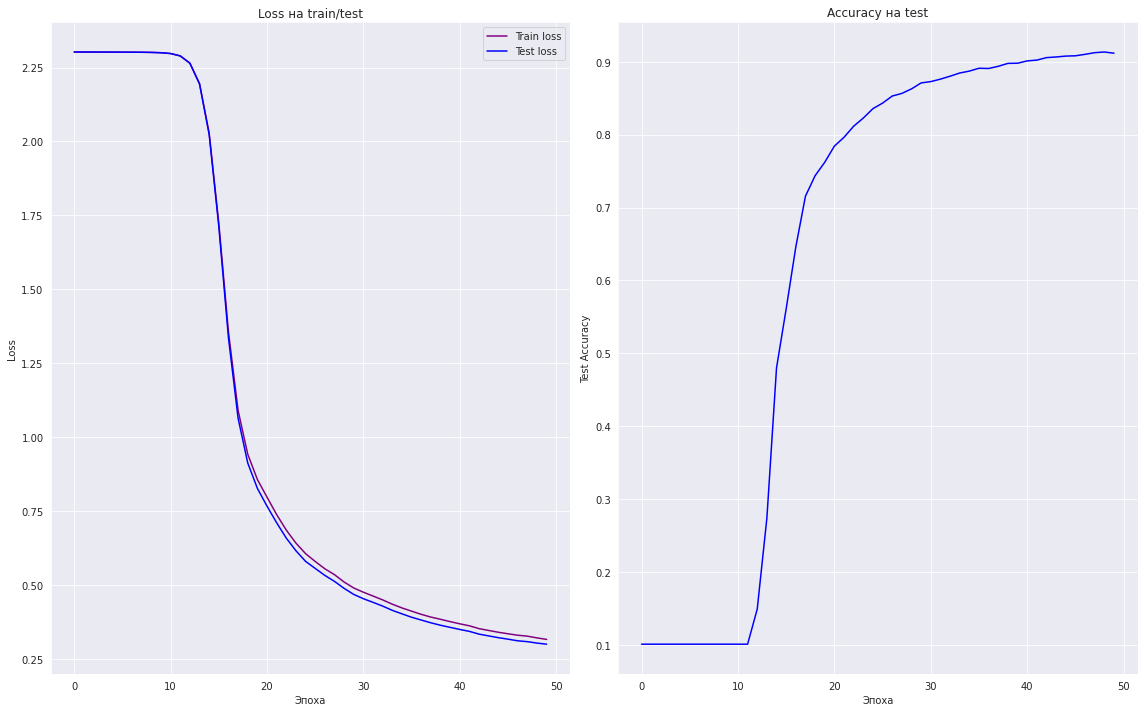

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

with sns.axes_style('darkgrid'):
  plt.figure(figsize=(16, 10))

  plt.subplot(1, 2, 1)
  plt.title('Loss на train/test')
  plt.plot(distr.history['iter'], train_loss, c='purple', lw=1.5, label='Train loss')
  plt.plot(distr.history['iter'], test_loss, c='blue', lw=1.5, label='Test loss')
  plt.xlabel('Эпоха')
  plt.ylabel('Loss')
  plt.legend(loc='best')

  plt.subplot(1, 2, 2)
  plt.title('Accuracy на test')
  plt.plot(distr.history['iter'], distr.history['test_accuracy'], c='blue', lw=1.5)
  plt.xlabel('Эпоха')
  plt.ylabel('Test Accuracy')

  plt.tight_layout()

Выводы

Тут это не видно - но лично у меня качетво очень сильно зависит от параметров num_global и num_local эпох - при малых значениях что loss что accuracy были не очень

Главный вывод - что можно расспараллеливать задачу и улучшать качество

# Задача 2*. [3]

1. [1] Найдите субдифференциал функции $f(x)=\|Ax-b\|_{\infty}$

2. [2] Покажите, что субдифференциал функции $f(x)=\|x\|_2$ в нуле есть $\partial f(0)=B_1(0)$.

**Решение**

1. [1]



# Задача 3. Periodic Signal Approximation [11]

Будем называть сигнал $x\in\mathbb{R}^n$ $p$-периодическим ($p<n$), если $x_{i+p}=x_i$, для $i=\overline{1\dots n-p}$.

В этой задаче мы рассмотрим задачу декомпозиции известного сигнала $y \in \mathbb{R}^n$ в сумму некоторых неизвестных периодических сигналов и некоторого шума. Иными словами, для заданного $y$ наша задача получить следующее разложение:
$$y=\sum\limits_{p\in \mathcal{P}} x^{(p)}+v,$$
где $x^{(p)}\in\mathbb{R}^n$ - искомые $p$-периодические сигналы, $\mathcal{P}\subseteq \{1\dots p_\max\}$ - неизвестное множество периодов (причем все периоды не превосходят заранее заданного $p_{\max}$, $v$ - остаточный шум.

Если бы $\mathcal{P}$ было бы известно, то мы могли бы достаточно легко найти $x^{(p)}$, используя метод наименьших квадратов:
$$\min_{x^{(p)}\in\mathbb{R}^n, p\in\mathcal{P}} \|y-\sum\limits_{p\in \mathcal{P}}x^{(p)}\|^2,$$
где $x^{(p)}$ все сигналы - $p$ периодические.

Однако поскольку ~~жизнь не сахар~~ $\mathcal{P}$ не известно, мы будем искать необходимые периодические компоненты среди всевозможных периодов $\{1\dots p_\max\}$, добавив регуляризатор, штрафующий за использование большого количества периодов:

$$\min_{x^{(p)}\in\mathbb{R}^n, p=\overline{1,p_{\max}}} \|y-\sum\limits_{p=1}^{p_{\max}} x^{(p)}\|^2+\sum\limits_{p=1}^{p_{\max}}w_p \|x^{(p)}\|_2,$$
$$\text{s.t. } \text{сигналы $x^{(p)}$ - $p$-периодические}.$$
$$$$
Коэффициенты регуляризации $w_p$ берут возрастающими.

*Не особо нужное для выполнения задания примечание:*
Известна стратегия добавить регуляризатор вида $R(x)=\|x\|_1$. Он занулит "лишние" веса и тем самым упростит модель. Однако что если Вы можете разбить Ваши признаки на некоторые группы и хотите сделать отбор именно по группам? В таком случае, $\ell_1$ регуляризатор может быть обобщен до вида $R(x)=\sum\limits_{g\in G} \|x_g\|_2,$ где $x_g$ - множество параметров, соотвествующей некоторой группе признаков $g$. Не сложно заметить, что прокс-оператор для такого регуляризатора (см. пункт 2 этой задачи) будет иметь вид похожий, на прокс-оператор для $\ell_1$-регуляризатора. Однако теперь он будет занулять не отдельные слишком малые коэффициенты, а сразу целую группу. Задача решения линейной регрессии с таким регуляризатором известна как **GroupLasso**. И аналагично, как для Lasso, можно показать, что в таком случае отбор будет происходить действительно по группам. Собственно, в данной задаче группами переменных у нас являются $p$-периодические сигналы. 

В пунктах 4-5 используйте сигнал $y$ сгенерированный ниже и веса $w_p=\sqrt{p}$.

1. [1] Формализируйте задачу выше 

2. [1*] Покажите, что решение $\min_{x\in \mathbb{R}^n}\left\{\|x\|_2 + \frac{1}{2\alpha}\|x-y\|_2^2\right\}$ дается следующей формулой:
$$x=y\left(1-\frac{\alpha}{\|y\|_2}\right)_+$$

3. [2] Переформулируйте задачу в пригодном виде для применения ADMM

4. [5] Выпишите шаги ADMM и их аналитические решения в явном виде


5. [3] Решите задачу выше при помощи cvxpy. Посмотрите на структуру решения.

6. [3*] Реализуйте метод ADMM для задачи выше

7. [2*] Сравните скорость сходимости метода ADMM для различных его параметров к известному из пункта 4 решению. Выберите лучшие параметры и не меняйте их далее

8. [2*] Далее Вам предлагается посмотреть на эффективность такого метода разложения на периоды для различной изначальной структуры $y$ и различных стратегий выбора весов $w_p$. Тут ожидается, что Вы сами придумаете качественно различные случаи $y$ и стратегий выбора весов $w_p$. Это творческое задание, чем интереснее будет Ваш анализ - тем лучше. Для получения ровно трех баллов вам достаточно проанализировать каких-нибудь два $y$ и две стратегии для $w_p$. В этом пункте Вы можете использовать как cvxpy, так и ADMM.

### Решение задачи 3:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
n = 300
eps = 1e-1
np.random.seed(1)
T_list = np.array([9,10, 50, 100])
X_p = np.sin(2 * np.pi * np.outer(1/T_list, np.arange(n)))
y = eps * np.random.randn(n) + X_p.sum(axis=0)
plt.plot(y)

In [ ]:
# Место для Вашего решения